
# Ejercicio 2.2: Face Recognition

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar una solucion para reconocimiento de facial. Se proveen datos de entrenamiento y es necesario entrenar un clasificador para hacer el reconocimiento. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



In [100]:
import cv2 
import numpy as np
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
import sys
import scipy.io

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure




### Cargar Datos de Entrenamiento y Validación


In [101]:
data_dir='./data'
face_recognition_dir = os.path.join(data_dir, 'face_recognition')
training_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_tr.mat')
validation_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_va.mat')

In [102]:
training_data_mat = scipy.io.loadmat(training_data_file)
validation_data_mat = scipy.io.loadmat(validation_data_file)

In [103]:
training_data=training_data_mat['tr_img_sample']
validation_data = validation_data_mat['va_img_sample']

In [104]:
class FeatureExtractors(enumerate):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, img):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(img)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(img)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(img)	
	
	return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
	resized_image = cv2.resize(img,resize_size)
	image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
	return image_representation
  
def extract_lbp_features(img):

	lbp_features = []
	
	resized_image = cv2.resize(img,(64,64))

	for a in range(int(len(resized_image)/3)):#Si el len de la imagen no es multiplo de 3 puede dejar afuera unos pixel
		x = 3*a
		for b in range(int(len(resized_image)/3)):
			y = 3*b
			block = [
				[resized_image[x,y], resized_image[x,y+1], resized_image[x,y+2]],
				[resized_image[x+1,y], resized_image[x+1,y+1], resized_image[x+1,y+2]],
				[resized_image[x+2,y], resized_image[x+2,y+1], resized_image[x+2,y+2]]
			]
		
			lbp_features.append(extract_lpb_single_block_3x3(block))
	return lbp_features

def extract_lpb_single_block_3x3(block):

    binary = ''
    center = block[1][1]

    binary += '1' if center < block[0][0] else '0'
    binary += '1' if center < block[0][1] else '0'
    binary += '1' if center < block[0][2] else '0'
    binary += '1' if center < block[1][2] else '0'
    binary += '1' if center < block[2][2] else '0'
    binary += '1' if center < block[2][1] else '0'
    binary += '1' if center < block[2][0] else '0'
    binary += '1' if center < block[1][0] else '0'

    return int(binary[::-1], 2) 

def extract_hog_features(img):
	resized_img = resize(img, (64, 64))

	fd = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
	cells_per_block=(2, 2))

	return fd


   

### Esqueleto de funciones para extracción de Features

### Armar los datos de entrenamiento y sus etiquetas

In [105]:
method = FeatureExtractors.HOG

In [106]:

training_images = []
training_labels = []
training_images_toprint = []
for training_image in training_data:
    image = (training_image[0]/255)
    image_features = extract_features(method, image)
    label = training_image[2]
    training_images.append(image_features)
    training_labels.append(label.reshape(1))
    training_images_toprint.append(image.reshape(64*64))

training_images = np.asarray(training_images)
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape(training_labels.shape[0])


In [107]:
training_labels.shape

(368,)

### Construir datos de validación y sus etiquetas


In [108]:
validation_images = []
validation_labels = []
validation_names = []
validation_images_toprint = []

for validation_image in validation_data:
    image = (validation_image[0]/255)
    image_features = extract_features(method, image)
    label = validation_image[2]
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image_features)
    validation_labels.append(label.reshape(1))
    validation_names.append(name)
    validation_images_toprint.append(image.reshape(64*64))

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])


In [109]:
#knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,algorithm='brute')
#knn_classifier.fit(training_images,training_labels)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(training_images, training_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

#### Guardar Modelo Entrenado

In [110]:
pickle.dump(clf,open('./face_recogition', 'wb'))

#### Cargar modelo

In [111]:
classifier = pickle.load(open('./face_recogition','rb'))

### Clasificar los datos de validación


In [112]:
labels = classifier.predict(validation_images)
## Get score for each sliding window patch
scores = classifier.predict_proba(validation_images)

###  Evaluar modelo de Reconocimento

In [113]:
acc = np.mean(labels==validation_labels)*100

In [114]:
print('The accuracy of face recognition is:%.2f \n' % acc)


The accuracy of face recognition is:42.34 



### Visualize Recognition ###

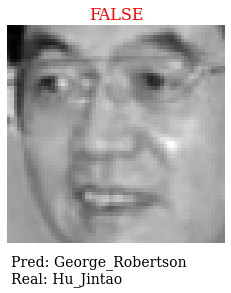

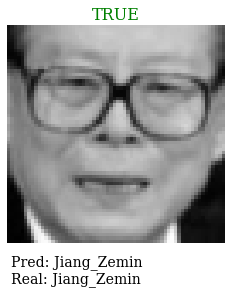

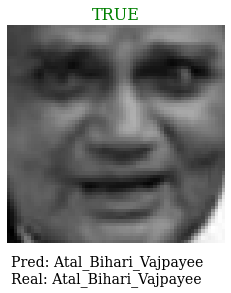

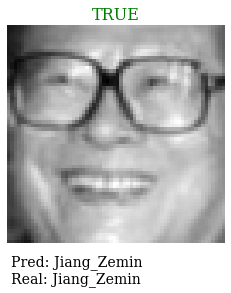

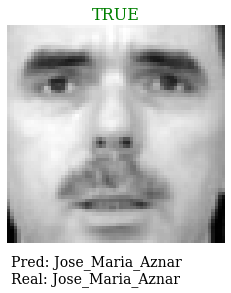

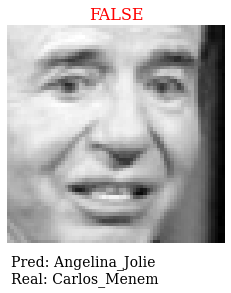

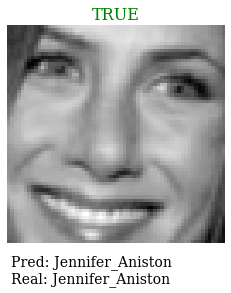

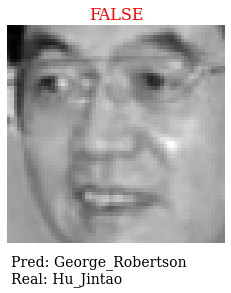

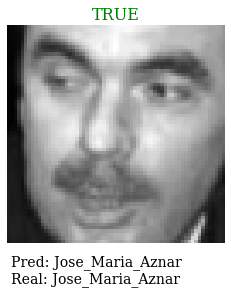

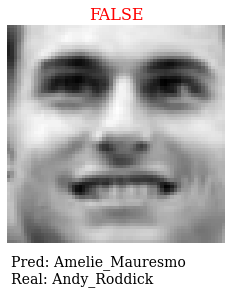

In [118]:
#indexes = [13,50,77,18,110,1,3,45,27] # You can use Random Sample
indexes = np.random.randint(0,len(validation_images_toprint),10);
for index in indexes:
    predicted_label=labels[index]
    real_label = validation_labels[index]

    pred_name = validation_names[np.nonzero(validation_labels==predicted_label)[0][0]]
    real_name = validation_names[np.nonzero(validation_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(validation_images_toprint[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()
